In [2]:
# import libraries
import argparse
import os
from torchvision import  models #,transforms, datasets
import torch

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14


In [3]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params:path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns: save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    model_name = model_name.split('/')[1]
    
    assert (model_name in ['resnet152']), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path, map_location={'cuda:0': 'cpu'})


    if model_name == 'resnet152':
        model = models.resnet152(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    # model.load_state_dict(checkpoint['state_dict'])


    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [4]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor.
    Param: image = image in tensor 
           ax = plot image using matplotlib 
           title = title for image
    Return: ax= plot image
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [5]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor
    Param: image_path(str) = image path to open image and convert to tensor 
    
    Return: img_tensor = image converted to tensor
    
    """

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [6]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params:image_path (str): filename of the image
           model (PyTorch model): trained model for inference
           topk (int): number of top predictions to return

    Returns:
        img_tensor =image in tensor 
        top_p = top n prediction
        top_classes = top n classes
        real_class = actual class


    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    #if train_on_gpu:
    #    img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    #else:
    img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]
        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [7]:
chk_pt_hab = './resnet152-transfer-4-Habitats_Dataset-128.pth'
hab_model, hab_optimizer = load_checkpoint(path=chk_pt_hab)

G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retr

output:  sparse residential area


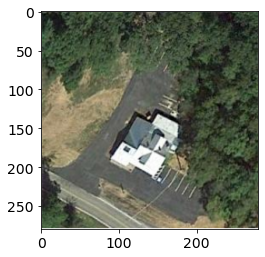

In [25]:
image = "./test_model/test_habitat/13.png"
img, top_p, top_classes, real_class = predict(image, hab_model)
plt.imshow(Image.open(image))
print("output: ", top_classes[0])

In [26]:
chk_pt_ani = './resnet152-transfer-4-Animals_Dataset-64.pth'
ani_model, ani_optimizer = load_checkpoint(path=chk_pt_ani)

G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\software-setups\anaconda\envs\pytorch_env\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retr

output:  bee


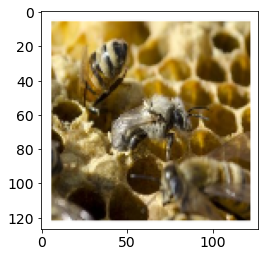

In [27]:
image = "./test_model/test_animal/A1.png"
img, top_p, top_classes, real_class = predict(image, ani_model)
plt.imshow(Image.open(image))
print("output: ", top_classes[0])